<a href="https://colab.research.google.com/github/Ha-minss/Personal-Projects/blob/main/Global%20Renewable%20Energy%20Usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
import kagglehub
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
files.upload()  # 여기서 kaggle.json 파일 선택

Saving kaggle.json to kaggle (7).json


{'kaggle (7).json': b'{"username":"ehdgk0725","key":"efa68270d8926dcaeb86446184e814ea"}'}

In [3]:
# 1) ~/.kaggle 디렉토리 생성
!mkdir -p ~/.kaggle
# 2) 업로드된 kaggle.json을 이동
!cp kaggle.json ~/.kaggle/
# 3) 권한 설정 (안전하게 읽기 전용)
!chmod 600 ~/.kaggle/kaggle.json
# 4) Kaggle API 클라이언트 설치
!pip install -q kaggle

In [4]:
# Download latest version
path = kagglehub.dataset_download("hajraamir21/global-renewable-energy-usage-2020-2024")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/global-renewable-energy-usage-2020-2024


In [5]:
# 1) 다운로드된 데이터셋 경로
base_path = "/root/.cache/kagglehub/datasets/hajraamir21/global-renewable-energy-usage-2020-2024/versions/1"
# 2) 폴더 안 파일 목록 확인
files = os.listdir(base_path)
print("Files in dataset folder:", files)

Files in dataset folder: ['Renewable_Energy_Usage_Sampled.csv']


In [6]:
# 3) CSV 파일 이름 골라서 읽기 (예: 'Renewable_Energy_Usage_Sampled.csv' 혹은 목록에서 확인된 이름으로 변경)
csv_name = [f for f in files if f.lower().endswith(".csv")][0]
csv_path = os.path.join(base_path, csv_name)
df = pd.read_csv(csv_path)
# 4) 데이터 확인
print(f"\nLoaded `{csv_name}` with shape:", df.shape)
df.head()


Loaded `Renewable_Energy_Usage_Sampled.csv` with shape: (1000, 12)


,Household_ID,Region,Country,Energy_Source,Monthly_Usage_kWh,Year,Household_Size,Income_Level,Urban_Rural,Adoption_Year,Subsidy_Received,Cost_Savings_USD
0,H01502,North America,USA,Hydro,1043.49,2024,5,Low,Urban,2012,No,10.46
1,H02587,Australia,Australia,Geothermal,610.01,2024,4,High,Rural,2023,No,43.49
2,H02654,North America,USA,Biomass,1196.75,2024,8,Low,Rural,2017,Yes,93.28
3,H01056,South America,Colombia,Biomass,629.67,2024,7,High,Urban,2023,No,472.85
4,H00706,Africa,Egypt,Hydro,274.46,2022,7,Middle,Rural,2010,No,65.98


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Household_ID       1000 non-null   object 
 1   Region             1000 non-null   object 
 2   Country            1000 non-null   object 
 3   Energy_Source      1000 non-null   object 
 4   Monthly_Usage_kWh  1000 non-null   float64
 5   Year               1000 non-null   int64  
 6   Household_Size     1000 non-null   int64  
 7   Income_Level       1000 non-null   object 
 8   Urban_Rural        1000 non-null   object 
 9   Adoption_Year      1000 non-null   int64  
 10  Subsidy_Received   1000 non-null   object 
 11  Cost_Savings_USD   1000 non-null   float64
dtypes: float64(2), int64(3), object(7)
memory usage: 93.9+ KB


In [8]:
df.describe()

,Monthly_Usage_kWh,Year,Household_Size,Adoption_Year,Cost_Savings_USD
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,767.325530,2021.992000,4.480000,2015.992000,248.389850
std,419.649102,1.419137,2.297581,3.973629,143.127301
min,50.740000,2020.000000,1.000000,2010.000000,10.420000
25%,402.730000,2021.000000,2.000000,2013.000000,122.122500
50%,760.190000,2022.000000,5.000000,2016.000000,242.530000
75%,1117.747500,2023.000000,6.000000,2019.000000,372.520000
max,1497.340000,2024.000000,8.000000,2024.000000,499.830000


,Cost_Savings_USD
count,1000.000000
mean,248.389850
std,143.127301
min,10.420000
25%,122.122500
50%,242.530000
75%,372.520000
max,499.830000


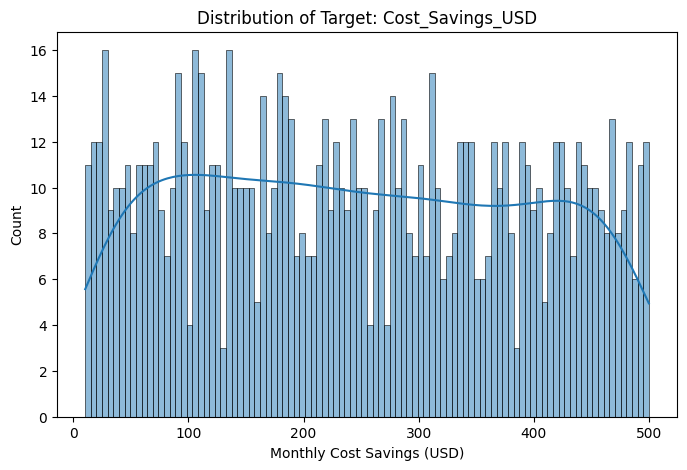

In [9]:
display(df['Cost_Savings_USD'].describe())
plt.figure(figsize=(8, 5))
sns.histplot(df['Cost_Savings_USD'], bins=100, kde=True)
plt.xlabel("Monthly Cost Savings (USD)")
plt.title("Distribution of Target: Cost_Savings_USD")
plt.show()

In [10]:
# 예시 코드
print(df['Subsidy_Received'].value_counts(normalize=True))   # 보조금 수령 비율
print("\n")

print(df['Income_Level'].value_counts(normalize=True))      # 소득 수준 분포
print("\n")

print(df['Urban_Rural'].value_counts(normalize=True))       # 도시/농촌 비율
print("\n")

print(df['Region'].value_counts())                          # 지역별 관측치 수
print("\n")

print(df['Energy_Source'].value_counts())                   # 에너지원별 관측치 수

Subsidy_Received
No     0.503
Yes    0.497
Name: proportion, dtype: float64


Income_Level
Middle    0.358
High      0.330
Low       0.312
Name: proportion, dtype: float64


Urban_Rural
Rural    0.514
Urban    0.486
Name: proportion, dtype: float64


Region
Europe           173
Australia        167
Africa           167
South America    166
North America    164
Asia             163
Name: count, dtype: int64


Energy_Source
Wind          227
Solar         201
Hydro         199
Biomass       193
Geothermal    180
Name: count, dtype: int64


                   Monthly_Usage_kWh  Cost_Savings_USD  Household_Size
Monthly_Usage_kWh           1.000000          0.000437       -0.024876
Cost_Savings_USD            0.000437          1.000000       -0.032560
Household_Size             -0.024876         -0.032560        1.000000






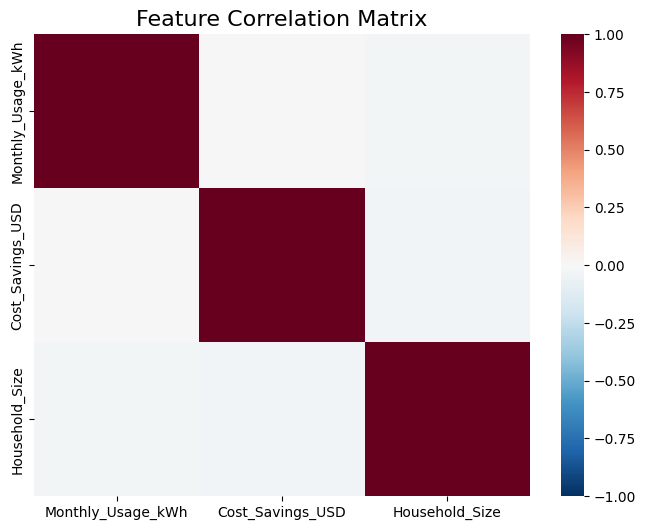

In [11]:
#상관관계파악
corr_matrix = df[['Monthly_Usage_kWh','Cost_Savings_USD','Household_Size']].corr()
print(corr_matrix)

print("\n")
print("\n")

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

In [12]:
#결측치 처리
print(df.isna().sum())

#결측치 비율
print((df.isna().mean() * 100).round(2))

Household_ID         0
Region               0
Country              0
Energy_Source        0
Monthly_Usage_kWh    0
Year                 0
Household_Size       0
Income_Level         0
Urban_Rural          0
Adoption_Year        0
Subsidy_Received     0
Cost_Savings_USD     0
dtype: int64
Household_ID         0.0
Region               0.0
Country              0.0
Energy_Source        0.0
Monthly_Usage_kWh    0.0
Year                 0.0
Household_Size       0.0
Income_Level         0.0
Urban_Rural          0.0
Adoption_Year        0.0
Subsidy_Received     0.0
Cost_Savings_USD     0.0
dtype: float64


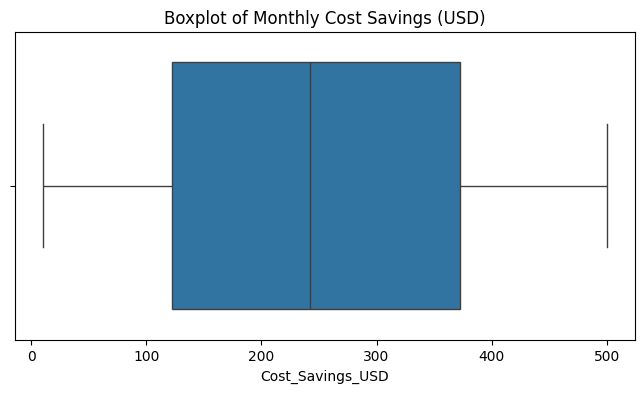

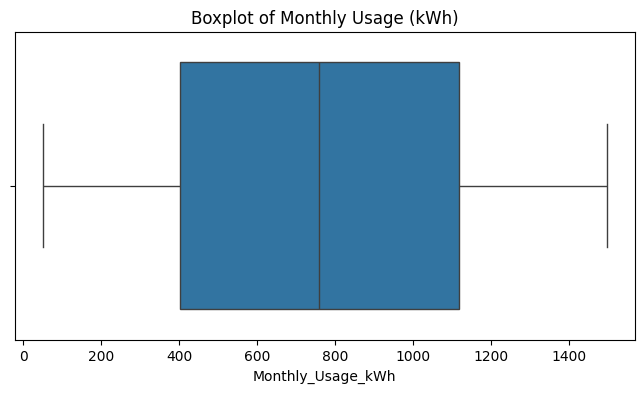

In [13]:
#이상치 체크
# Boxplot for Cost_Savings_USD
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Cost_Savings_USD'])
plt.title("Boxplot of Monthly Cost Savings (USD)")
plt.xlabel("Cost_Savings_USD")
plt.show()

# Boxplot for Monthly_Usage_kWh
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Monthly_Usage_kWh'])
plt.title("Boxplot of Monthly Usage (kWh)")
plt.xlabel("Monthly_Usage_kWh")
plt.show()

In [14]:
#왜도첨도 측정
for col in ['Monthly_Usage_kWh','Cost_Savings_USD']:
  print(col,
        "skew", skew(df[col].dropna()).round(3),
        "kurtosis", kurtosis(df[col].dropna()).round(3))

Monthly_Usage_kWh skew 0.003 kurtosis -1.203
Cost_Savings_USD skew 0.069 kurtosis -1.212


In [15]:
# 2) 기존 순서형/이진형 더미 생성
df['Subsidy_Received_dummy'] = (df['Subsidy_Received'] == 'Yes').astype(int)
df['Income_Level_dummy']    = df['Income_Level'].map({'Low':0,'Middle':1,'High':2})
df['Urban_Rural_dummy']     = (df['Urban_Rural'] == 'Urban').astype(int)

# 1) 파생 피처 추가
df['Years_Since_Adoption'] = df['Year'] - df['Adoption_Year']
df['Cost_Savings_per_Person'] = df['Cost_Savings_USD'] / df['Household_Size']
df['Usage_per_Person'] = df['Monthly_Usage_kWh'] / df['Household_Size']
df['ROI'] = df['Cost_Savings_USD'] / df['Monthly_Usage_kWh']
df['subsidy_income_interaction'] = df['Subsidy_Received_dummy'] * df['Income_Level_dummy']
df['Usage_per_Person_sq'] = df['Usage_per_Person'] ** 2

# 2) Year, Adoption_Year -> Label Encoding
le_year = LabelEncoder()
df['Year_le'] = le_year.fit_transform(df['Year'])
le_adopt = LabelEncoder()
df['Adoption_Year_le'] = le_adopt.fit_transform(df['Adoption_Year'])

# 3) 범주형(Label Encoding) → Region, Country, Energy_Source
for col in ['Region', 'Country', 'Energy_Source']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col])

# 4) 불필요 컬럼 제거
df.drop(columns=[
    'Year', 'Adoption_Year',
    'Region', 'Country', 'Energy_Source'
], inplace=True)

# 5) 피처, 타깃 설정
features = [
    'Years_Since_Adoption', 'Year_le', 'Adoption_Year_le',
    'Cost_Savings_per_Person', 'Usage_per_Person', 'Usage_per_Person_sq', 'ROI',
    'Subsidy_Received_dummy', 'Income_Level_dummy', 'Urban_Rural_dummy',
    'subsidy_income_interaction',
    'Region_le', 'Country_le', 'Energy_Source_le'
]
X = df[features]
y = df['Cost_Savings_USD']


print("New feature set:", X.columns.tolist())
print("X shape:", X.shape)
print("y shape:", y.shape)

New feature set: ['Years_Since_Adoption', 'Year_le', 'Adoption_Year_le', 'Cost_Savings_per_Person', 'Usage_per_Person', 'Usage_per_Person_sq', 'ROI', 'Subsidy_Received_dummy', 'Income_Level_dummy', 'Urban_Rural_dummy', 'subsidy_income_interaction', 'Region_le', 'Country_le', 'Energy_Source_le']
X shape: (1000, 14)
y shape: (1000,)


In [16]:
# 1) Random Forest 내장 중요도 (전체 데이터)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("=== Top 20 (RF.feature_importances_ on full data) ===")
print(imp_df.head(20))

# 2) Permutation Importance (전체 데이터)
perm = permutation_importance(
    rf, X, y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm.importances_mean,
    'importance_std':  perm.importances_std
}).sort_values('importance_mean', ascending=False)

print("\n=== Top 20 (permutation_importance on full data) ===")
print(perm_df.head(20))

=== Top 20 (RF.feature_importances_ on full data) ===
                       feature  importance
3      Cost_Savings_per_Person    0.482593
6                          ROI    0.381383
12                  Country_le    0.021997
0         Years_Since_Adoption    0.016865
2             Adoption_Year_le    0.015840
4             Usage_per_Person    0.015648
5          Usage_per_Person_sq    0.015398
13            Energy_Source_le    0.011249
11                   Region_le    0.010879
1                      Year_le    0.009899
10  subsidy_income_interaction    0.005630
8           Income_Level_dummy    0.005047
9            Urban_Rural_dummy    0.004269
7       Subsidy_Received_dummy    0.003302

=== Top 20 (permutation_importance on full data) ===
                       feature  importance_mean  importance_std
3      Cost_Savings_per_Person         0.879023        0.032741
6                          ROI         0.769091        0.024078
12                  Country_le         0.030035        

In [17]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
# 2) Manually chosen hyperparameters for speed + new models
base_estimators = [
    ('rf',   Pipeline([('scale', StandardScaler()),
                       ('model', RandomForestRegressor(n_estimators=300, max_depth=30, random_state=42, n_jobs=-1))])),
    ('gb',   Pipeline([('scale', StandardScaler()),
                       ('model', GradientBoostingRegressor(n_estimators=80, learning_rate=0.1, max_depth=4, random_state=42))])),
    ('xgb',  Pipeline([('scale', StandardScaler()),
                       ('model', XGBRegressor(n_estimators=60, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1, verbosity=0))])),
    # 추가: LightGBM
    ('lgbm', Pipeline([('scale', StandardScaler()),
                       ('model', LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42))])),
    # 추가: Decision Tree
    ('dt',   Pipeline([('scale', StandardScaler()),
                       ('model', DecisionTreeRegressor(max_depth=10, random_state=42))])),
]

# 3) Define stacking with a lightweight meta-model
stack_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42, verbosity=0),
    cv=8,
    n_jobs=-1,
    passthrough=False
)

# 4) Fit and evaluate as before
stack_model.fit(X_train, y_train)

print("=== Base Model Metrics ===")
for name, fitted_pipe in stack_model.named_estimators_.items():
    y_pred = fitted_pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_val = mean_absolute_percentage_error(y_test, y_pred) * 100
    print(f"{name:>6} RMSE: {rmse:.2f}, MAPE: {mape_val:.2f}%")

y_pred_stack = stack_model.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mape_stack = mean_absolute_percentage_error(y_test, y_pred_stack) * 100
print(f"\nStacking Model RMSE: {rmse_stack:.2f}, MAPE: {mape_stack:.2f}%")


=== Base Model Metrics ===
    rf RMSE: 67.22, MAPE: 28.61%
    gb RMSE: 67.86, MAPE: 30.22%
   xgb RMSE: 70.49, MAPE: 31.13%
  lgbm RMSE: 68.81, MAPE: 32.40%
    dt RMSE: 89.11, MAPE: 35.49%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Stacking Model RMSE: 69.99, MAPE: 31.76%
